<h1> Tropical Watch - Historical Prices Tracker </h1>

In [122]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime as dt
from concurrent.futures import ThreadPoolExecutor
import os, json

BASE_URL = "https://tropicalwatch.com"
JSON_FILE = "watch_data.json"
SESSION = requests.Session()

def extract_watch_details(watch_soup):
    title = watch_soup.find("h2").text.strip().title()
    details_url = watch_soup.find("a")["href"]
    details_page = fetch_watch_details_page(BASE_URL + details_url)
    details_soup = BeautifulSoup(details_page, "html.parser")
    additional_details = extract_additional_details(details_soup)

    # Normalize text data
    brand = additional_details["Brand"].capitalize() if additional_details["Brand"] else None
    model = additional_details["Model"].capitalize() if additional_details["Model"] else None

    # Validate year data
    year = additional_details["Year"]
    try:
        year = int(year) if year.isdigit() else None
    except ValueError:
        year = None

    # Handle price data
    price_text = additional_details["Price"].replace('$', '').replace(',', '').lower()
    if price_text == "sold":
        price = "sold"
    else:
        try:
            price = float(price_text)
        except ValueError:
            price = None  # If price can't be converted to float, keep it as None

    return {
        "Title": title,
        "Year": year,
        "Brand": brand,
        "Model": model,
        "Reference": additional_details["Reference"],
        "Serial": additional_details["Serial"],
        "Inventory": details_url,
        "PriceHistory": [{"Date": dt.today().isoformat(), "Price": price}]
    }


def fetch_watch_details_page(url):
    try:
        response = SESSION.get(url)
        response.raise_for_status()
        return response.content
    except requests.exceptions.RequestException as e:
        print(f"Error fetching page: {e}")
        return None

def extract_additional_details(details_soup):
    details_table = details_soup.find("table", {"class": "watch-main-details-table"})
    price_element = details_soup.find("h2", {"class": "watch-main-price"})
    price_text = price_element.text.strip() if price_element else "N/A"
    details = {
        "Price": price_text.lower(),
        "Year": "N/A",
        "Brand": "N/A",
        "Model": "N/A",
        "Reference": "N/A",
        "Serial": "N/A"
    }
    try:
        details["Year"] = details_table.find("th", string="Year").find_next("td").text.strip()
        details["Brand"] = details_table.find("th", string="Brand").find_next("td").text.strip()
        details["Model"] = details_table.find("th", string="Model").find_next("td").text.strip()
        details["Reference"] = details_table.find("th", string="Reference").find_next("td").text.strip()
        details["Serial"] = details_table.find("th", string="Serial").find_next("td").text.strip()
    except AttributeError:
        pass
    return details

def fetch_page_data(url):
    try:
        response = SESSION.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        watch_list = soup.find("ol", {"id": "watch-list"})

        # Return an empty list if no watch list is found on the page
        if watch_list is None:
            return []

        with ThreadPoolExecutor() as executor:
            return list(executor.map(extract_watch_details, watch_list.find_all("li", {"class": "watch"})))
    except requests.exceptions.RequestException as e:
        print(f"Error fetching page data: {e}")
        return []


def save_to_json(data, json_file):
    if os.path.exists(json_file):
        with open(json_file, 'r', encoding='utf-8') as file:
            existing_data = json.load(file)
        existing_data_dict = {watch["Inventory"]: watch for watch in existing_data}
        current_date = dt.today().isoformat()

        for watch in data:
            inventory = watch["Inventory"]
            if inventory in existing_data_dict:
                existing_watch = existing_data_dict[inventory]
                last_price = existing_watch["PriceHistory"][-1]["Price"]
                new_price = watch["PriceHistory"][0]["Price"]
                if last_price != new_price:
                    print(f"Price changed for {watch['Title']} (Inventory: {inventory}). Old Price: {last_price}, New Price: {new_price}. Updating...")
                    existing_watch["PriceHistory"].append({"Date": current_date, "Price": new_price})
            else:
                print(f"New watch found: {watch['Title']} (Inventory: {inventory}). Adding to the JSON.")
                existing_data_dict[inventory] = watch

        with open(json_file, 'w', encoding='utf-8') as file:
            json.dump(list(existing_data_dict.values()), file, indent=4)
    else:
        with open(json_file, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)

def main():
    page_number = 1
    all_watch_details = []

    while True:
        page_url = f"{BASE_URL}/?page={page_number}"
        page_data = fetch_page_data(page_url)

        if not page_data:
            break  # Break the loop if no data is returned (indicating the end of pages)

        all_watch_details.extend(page_data)
        page_number += 1  # Increment the page number

    # Save the data to a JSON file
    save_to_json(all_watch_details, JSON_FILE)
    print(f"Data saved to {JSON_FILE}")

if __name__ == "__main__":
    main()


Price changed for 2023 Rolex 18K Rg Daytona 126515Ln Black Diamond Dial With Box And Papers (Inventory: /watches/kknh). Old Price: 42850.0, New Price: 41850.0. Updating...
Price changed for 2000 Rolex Explorer Ii 16570 Black Dial With Papers (Inventory: /watches/acf0). Old Price: 7650.0, New Price: 6950.0. Updating...
Price changed for 2005 Patek Philippe Nautilus 3710 Matte Black Dial With Papers (Inventory: /watches/7sst). Old Price: 78550.0, New Price: 77550.0. Updating...
Price changed for 1990 Rolex 18K Yg Day-Date 18238 Mother Of Pearl Diamond Pave Dial (Inventory: /watches/s7x1). Old Price: 31550.0, New Price: 29850.0. Updating...
Price changed for 1993 Rolex 18K Yg Submariner 16618 Champagne Serti Dial (Inventory: /watches/sf1a). Old Price: 25350.0, New Price: 24850.0. Updating...
Price changed for 1991 Rolex Submariner 14060 (Inventory: /watches/akmd). Old Price: 8850.0, New Price: sold. Updating...
Price changed for 2002 Rolex Air-King 14000M Black Dial (Inventory: /watches/a

In [123]:
import json
from datetime import datetime
import pandas as pd

def format_price(price):
    """Formats the price as a comma-separated string or returns 'sold'."""
    if isinstance(price, (float, int)):
        return f"${price:,.2f}"
    return price

def create_hyperlink(url, text):
    """Creates an HTML hyperlink."""
    return f'<a href="{url}" target="_blank">{text}</a>'

def update_portfolio_statistics(statistics_path, today_str, data):
    """Updates portfolio statistics JSON file."""
    try:
        with open(statistics_path, "r+", encoding="utf-8") as file:
            all_statistics = json.load(file)
    except (json.JSONDecodeError, FileNotFoundError):
        all_statistics = {}

    all_statistics[today_str] = data

    with open(statistics_path, "w", encoding="utf-8") as file:
        json.dump(all_statistics, file, indent=4)

# Load the JSON file
json_file_path = 'watch_data.json'
with open(json_file_path, 'r', encoding='utf-8') as file:
    watch_data = json.load(file)

# Get today's date as a string
today_str = datetime.today().strftime('%Y-%m-%d')

# Data lists for tables and summary statistics
price_changes_data = []
new_additions_data = []
watches_sold_data = []
num_watches_sold = num_watches_added = num_watches_for_sale = 0
value_of_sold_watches = value_of_listed_watches = value_of_unsold_watches = 0

# BASE_URL - define your base URL here
BASE_URL = "https://tropicalwatch.com"

# Iterate through the watches in the JSON file
for watch in watch_data:
    last_price_entry = watch["PriceHistory"][-1]
    last_price_date = last_price_entry["Date"].split('T')[0]
    last_price = last_price_entry["Price"]

    if last_price_date == today_str:
        inventory_url = create_hyperlink(f"{BASE_URL}{watch['Inventory']}", "Link")
        if len(watch["PriceHistory"]) > 1:
            previous_price_entry = watch["PriceHistory"][-2]
            previous_price = previous_price_entry["Price"]

            formatted_last_price = format_price(last_price)
            formatted_previous_price = format_price(previous_price)

            if last_price == "sold":
                watches_sold_data.append([watch['Title'], "Sold", inventory_url])
                if isinstance(previous_price, (float, int)):
                    value_of_sold_watches += previous_price
                    num_watches_sold += 1
            else:
                price_changes_data.append([watch['Title'], formatted_previous_price, formatted_last_price, inventory_url])
        else:
            formatted_last_price = format_price(last_price)
            new_additions_data.append([watch['Title'], formatted_last_price, inventory_url])
            if isinstance(last_price, (float, int)):
                value_of_listed_watches += last_price
                num_watches_added += 1

    # Counting and valuing unsold watches
    if last_price != "sold":
        num_watches_for_sale += 1
        if isinstance(last_price, (float, int)):
            value_of_unsold_watches += last_price

# Create DataFrames for display
price_changes_df = pd.DataFrame(price_changes_data, columns=['Title', 'Old Price', 'New Price', 'Inventory URL'])
new_additions_df = pd.DataFrame(new_additions_data, columns=['Title', 'Price', 'Inventory URL'])
watches_sold_df = pd.DataFrame(watches_sold_data, columns=['Title', 'Status', 'Inventory URL'])

# Display the tables as HTML
from IPython.display import HTML
print("Price Changes Today:")
display(HTML(price_changes_df.to_html(escape=False, index=False)))

print("\nNew Additions Today:")
display(HTML(new_additions_df.to_html(escape=False, index=False)))

print("\nWatches Sold Today:")
display(HTML(watches_sold_df.to_html(escape=False, index=False)))

# Output the summary statistics with formatted values
formatted_sold_value = format_price(value_of_sold_watches)
formatted_listed_value = format_price(value_of_listed_watches)
formatted_unsold_value = format_price(value_of_unsold_watches)
print(f"\nValue of sold Watches: {formatted_sold_value}")
print(f"Value of listed Watches: {formatted_listed_value}")
print(f"Value of unsold Watches: {formatted_unsold_value}")

# Portfolio statistics for the day
daily_statistics = {
    "Number of Watches For Sale": num_watches_for_sale,
    "Number of Watches Sold": num_watches_sold,
    "Number of Watches Added": num_watches_added,
    "Total Value of Watches For Sale": formatted_unsold_value,
    "Total Value of Watches Sold": formatted_sold_value,
    "Total Value of Watches Added": formatted_listed_value
}

# Update portfolio statistics JSON file
update_portfolio_statistics("portfolio_statistics.json", today_str, daily_statistics)


Price Changes Today:


Title,Old Price,New Price,Inventory URL
1990 Rolex 18K Yg Day-Date 18238 Mother Of Pearl Diamond Pave Dial,"$31,550.00","$29,850.00",Link
2005 Patek Philippe Nautilus 3710 Matte Black Dial With Papers,"$78,550.00","$77,550.00",Link
1993 Rolex 18K Yg Submariner 16618 Champagne Serti Dial,"$25,350.00","$24,850.00",Link
2000 Rolex Explorer Ii 16570 Black Dial With Papers,"$7,650.00","$6,950.00",Link
2023 Rolex 18K Rg Daytona 126515Ln Black Diamond Dial With Box And Papers,"$42,850.00","$41,850.00",Link



New Additions Today:


Title,Price,Inventory URL



Watches Sold Today:


Title,Status,Inventory URL
2002 Rolex Gmt-Master 16710 With Papers,Sold,Link
1988 Rolex 18K Yg Day-Date 18238 Champagne Diamond Dial,Sold,Link
2002 Rolex Air-King 14000M Black Dial,Sold,Link
1991 Rolex Submariner 14060,Sold,Link



Value of sold Watches: $40,100.00
Value of listed Watches: $0.00
Value of unsold Watches: $4,445,150.00



Summary Statistics:
       PriceHistory_Price
count          243.000000
mean         20701.028807
std          19090.241032
min            950.000000
25%           9850.000000
50%          15650.000000
75%          25550.000000
max         153550.000000


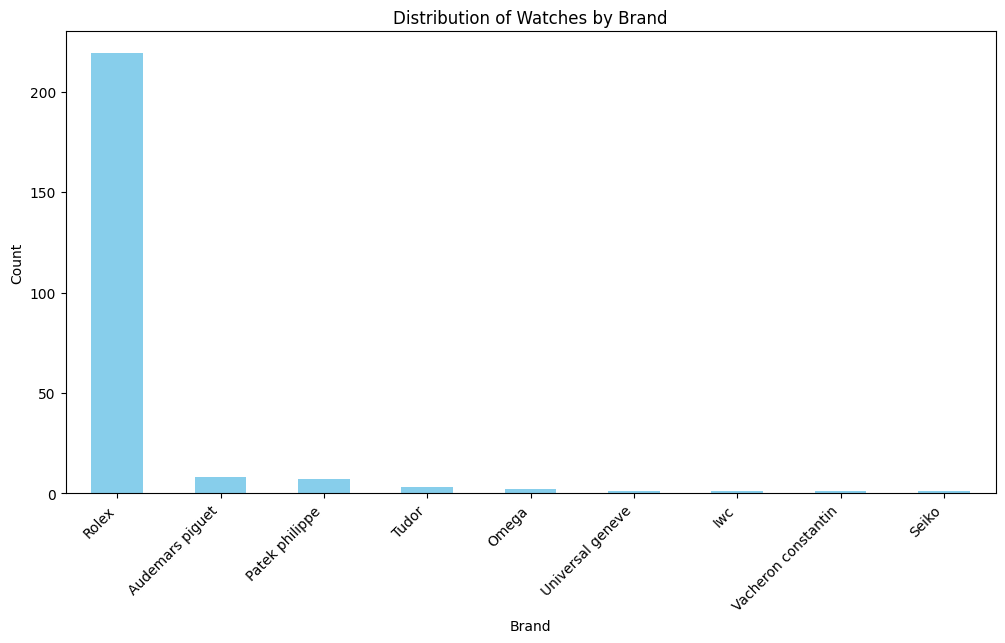

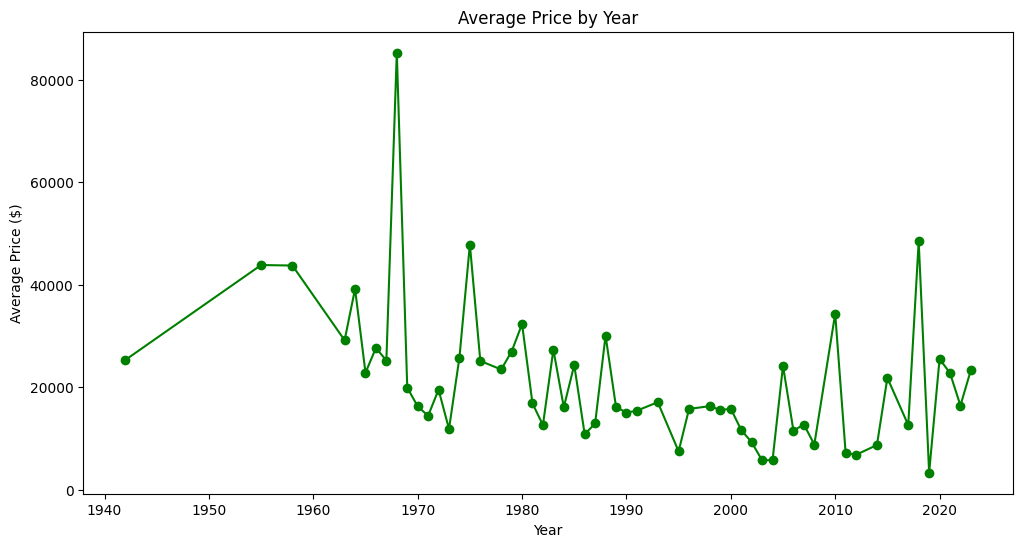

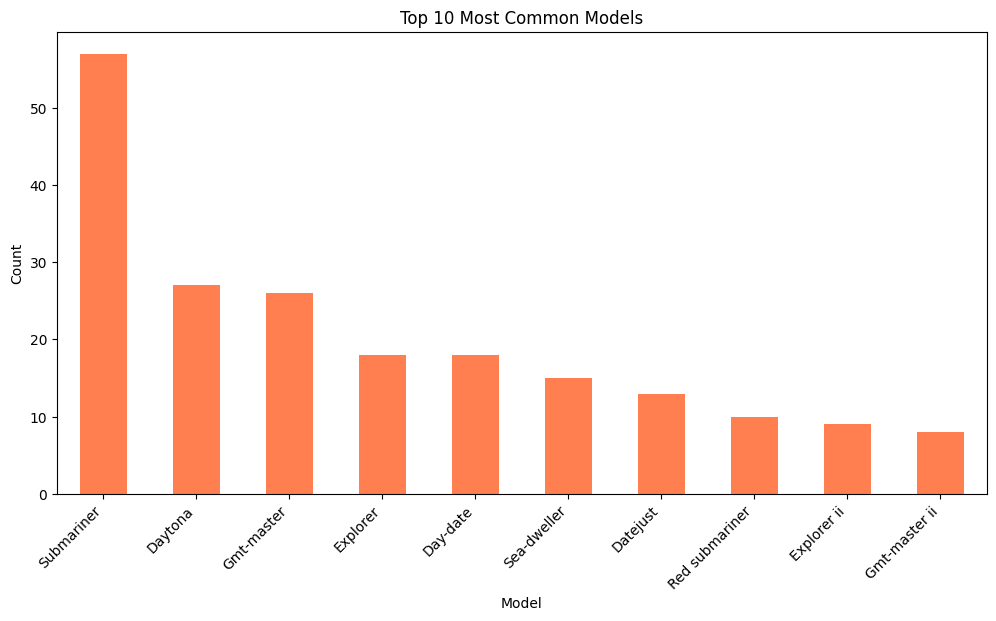

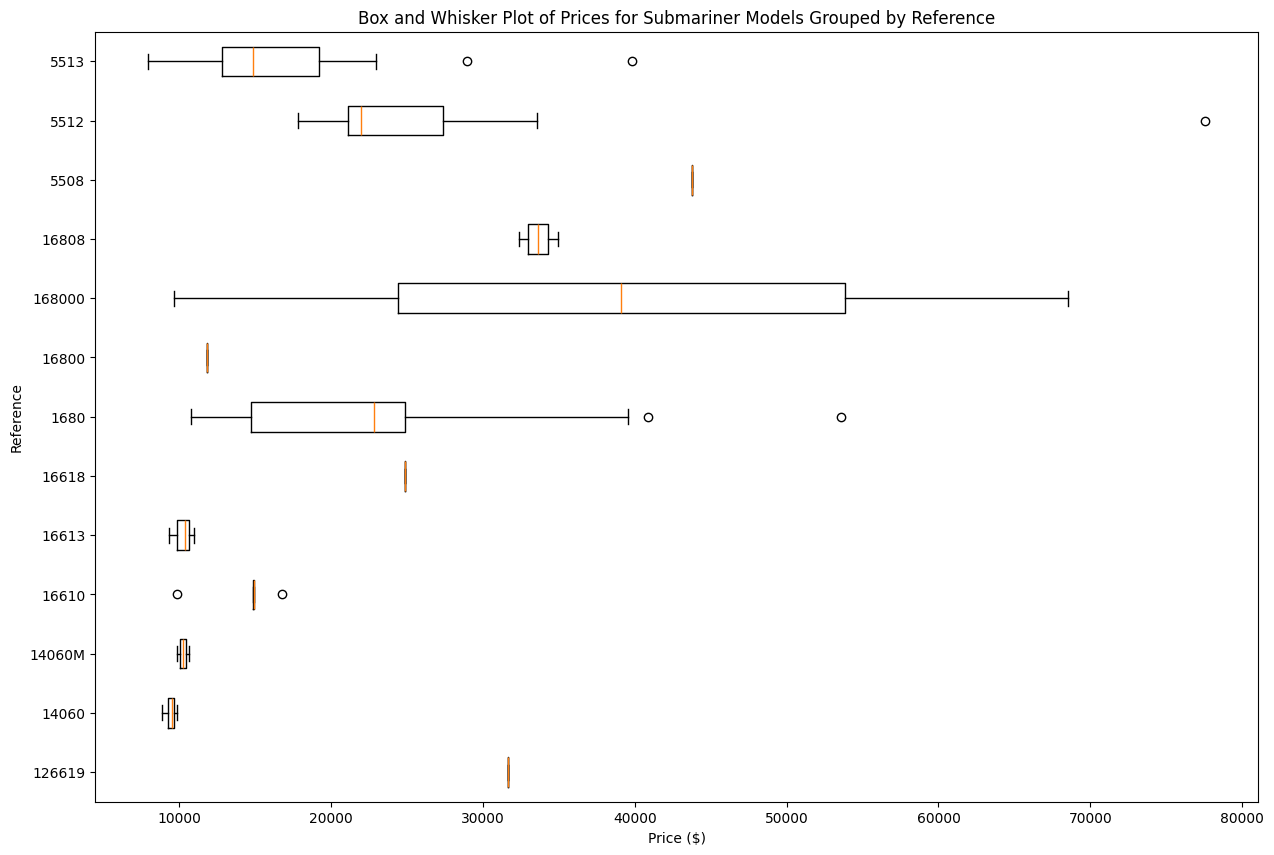

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON file
json_file = "watch_data.json"
with open(json_file, 'r') as file:
    data = json.load(file)

# Flatten the PriceHistory
df_watches = pd.json_normalize(data, 'PriceHistory', 
                               ['Title', 'Year', 'Brand', 'Model', 'Reference', 'Serial', 'Inventory'],
                               record_prefix='PriceHistory_')

#print(df_watches[df_watches['Inventory'].str.contains('/watches/owvi')])

# Convert 'Price' to numeric, setting 'sold' to NaN
df_watches['PriceHistory_Price'] = pd.to_numeric(df_watches['PriceHistory_Price'], errors='coerce')

# Assuming you want the latest price for each watch
df_latest_price = df_watches.sort_values(by=['Inventory', 'PriceHistory_Date']).groupby('Inventory').last().reset_index()

# Filter out rows where price is NaN (which includes 'sold')
df_latest_price = df_latest_price.dropna(subset=['PriceHistory_Price'])


# Basic information about the dataset
# print("Dataset Information:")
# print(df_latest_price.info())

# Summary statistics of numeric columns
print("\nSummary Statistics:")
print(df_latest_price.describe())

# Distribution of watches by brand
plt.figure(figsize=(12, 6))
df_latest_price['Brand'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Watches by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Average price of watches over the years
plt.figure(figsize=(12, 6))
df_latest_price.groupby('Year')['PriceHistory_Price'].mean().plot(marker='o', linestyle='-', color='green')
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.show()

# Distribution of watch models
model_counts = df_latest_price['Model'].value_counts().head(10)
plt.figure(figsize=(12, 6))
model_counts.plot(kind='bar', color='coral')
plt.title('Top 10 Most Common Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Filter the DataFrame for Submariner models
df_submariners = df_latest_price[df_latest_price['Model'].str.contains('Submariner', case=False, na=False)]
# Group by 'Reference' and prepare data for the plot
grouped_data = df_submariners.groupby('Reference')['PriceHistory_Price'].apply(list)
# Plotting
plt.figure(figsize=(15, 10))
plt.boxplot(grouped_data, labels=grouped_data.index, vert=False)
plt.title('Box and Whisker Plot of Prices for Submariner Models Grouped by Reference')
plt.xlabel('Price ($)')
plt.ylabel('Reference')
plt.show()

In [125]:
#Filter the DataFrame for Submariner models
display(df_latest_price[df_latest_price['Model'].str.contains('GMT-Master', case=False, na=False)].sort_values(by=['PriceHistory_Price']).head())

,Inventory,PriceHistory_Date,PriceHistory_Price,Title,Year,Brand,Model,Reference,Serial
4634,/watches/uvca,2024-01-08T22:33:20.040611,10550.0,1999 Rolex Gmt-Master Ii 16710,1999,Rolex,Gmt-master ii,16710,A782XXX
1189,/watches/bgmq,2024-01-08T22:33:16.419895,10750.0,1970 Rolex Two-Tone Gmt-Master 1675 Brown Nipp...,1970,Rolex,Gmt-master,1675,2463XXX
2447,/watches/ifgp,2024-01-08T22:33:16.748587,10750.0,1999 Rolex Gmt-Master 16700 Swiss Only Dial,1999,Rolex,Gmt-master,16700,A368XXX
720,/watches/7jpi,2024-01-11T19:45:40.748480,10850.0,1990 Rolex Gmt-Master 16700,1990,Rolex,Gmt-master,16700,E127XXX
1063,/watches/appt,2024-01-08T22:33:15.556039,10850.0,2001 Rolex Gmt-Master Ii 16710,2001,Rolex,Gmt-master ii,16710,Y328XXX


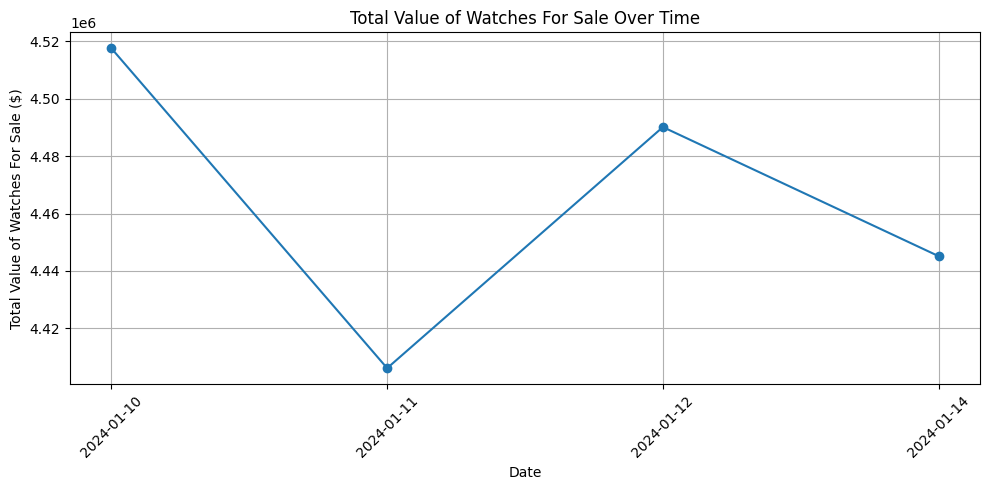

In [126]:
import json
import matplotlib.pyplot as plt

# Load the portfolio statistics JSON file
statistics_file_path = 'portfolio_statistics.json'
with open(statistics_file_path, 'r', encoding='utf-8') as file:
    portfolio_statistics = json.load(file)

# Extract dates and total values of watches for sale
dates = []
total_values_for_sale = []

for date, stats in portfolio_statistics.items():
    dates.append(date)
    # Convert formatted string back to float
    total_value = stats["Total Value of Watches For Sale"].replace('$', '').replace(',', '')
    total_values_for_sale.append(float(total_value))

# Sort data by date if needed
dates, total_values_for_sale = zip(*sorted(zip(dates, total_values_for_sale)))

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(dates, total_values_for_sale, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Value of Watches For Sale ($)')
plt.title('Total Value of Watches For Sale Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


<h1> Generate HTML Report </h1>

In [127]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the JSON data
json_file_path = 'watch_data.json'
with open(json_file_path, 'r', encoding='utf-8') as file:
    watch_data = json.load(file)

# Process data
today_str = datetime.today().strftime('%Y-%m-%d')
new_additions_data, price_changes_data, watches_sold_data = [], [], []
value_of_sold_watches, value_of_listed_watches = 0, 0

for watch in watch_data:
    last_entry = watch["PriceHistory"][-1]
    if last_entry["Date"].startswith(today_str):
        if len(watch["PriceHistory"]) > 1:
            prev_entry = watch["PriceHistory"][-2]
            
            # Handle price changes or watches sold
            if last_entry["Price"] == "sold":
                prev_price = prev_entry["Price"]
                watches_sold_data.append({
                    "Title": watch["Title"],
                    "Sold For": prev_price,
                    "Inventory URL": f"{BASE_URL}{watch['Inventory']}"
                })
                value_of_sold_watches += prev_price if isinstance(prev_price, (int, float)) else 0
            else:
                price_changes_data.append({
                    "Title": watch["Title"],
                    "Old Price": prev_entry["Price"],
                    "New Price": last_entry["Price"],
                    "Inventory URL": f"{BASE_URL}{watch['Inventory']}"
                })
        elif isinstance(last_entry["Price"], (int, float)):
            # Handle new additions
            new_additions_data.append({
                "Title": watch["Title"],
                "Listed Price": last_entry["Price"],
                "Inventory URL": f"{BASE_URL}{watch['Inventory']}"
            })
            value_of_listed_watches += last_entry["Price"]


# Create pandas DataFrames
new_additions_df = pd.DataFrame(new_additions_data)
price_changes_df = pd.DataFrame(price_changes_data)
watches_sold_df = pd.DataFrame(watches_sold_data)

# Generate a simple bar chart for summary statistics
plt.figure(figsize=(8, 4))
sns.barplot(x=['Sold Watches', 'Listed Watches'], y=[value_of_sold_watches, value_of_listed_watches])
plt.title('Value of Watches: Sold vs Listed')
plt.ylabel('Total Value ($)')
plt.savefig('summary_chart.png')
plt.close()

# Construct HTML content
html_content = f"""
<html>
<head>
    <title>Watch Data Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h1>Watch Data Report - {today_str}</h1>
    
    <h2>New Additions Today</h2>
    {new_additions_df.to_html(index=False, escape=False)}

    <h2>Price Changes Today</h2>
    {price_changes_df.to_html(index=False, escape=False)}

    <h2>Watches Sold Today</h2>
    {watches_sold_df.to_html(index=False, escape=False)}

    <h2>Summary Chart</h2>
    <img src="summary_chart.png" alt="Summary Chart">

    <p><strong>Total Value of Sold Watches:</strong> ${value_of_sold_watches:,.2f}</p>
    <p><strong>Total Value of Listed Watches:</strong> ${value_of_listed_watches:,.2f}</p>
</body>
</html>
"""

# Write the HTML content to a file
with open("watch_report.html", "w") as file:
    file.write(html_content)
